# 3. domácí úkol
## Načtení dat + výpočet četnosti písmen

In [158]:
import typing
import collections
from scipy import stats
import numpy as np

f1 = open("../001.txt", "r")
f7 = open("../007.txt", "r")

def countOccurences(X: list):
    a =  collections.OrderedDict(sorted(collections.Counter(X).items()))
    return list(a.keys()), list(a.values())

def characters(f: typing.TextIO):
    occurrences = []
    lines = f.readlines()
    for line in lines[1:]:    # skip first line
        occurrences = occurrences + list(line)
    return np.array(occurrences).flatten()

X1 = characters(f1)
X7 = characters(f7)

## Četnost jednotlivých písmen
Z textů jsou napočítané výskyty jednotlivých písmen a to včetně mezer.
> Písmeno ' ' reprezentuje mezeru

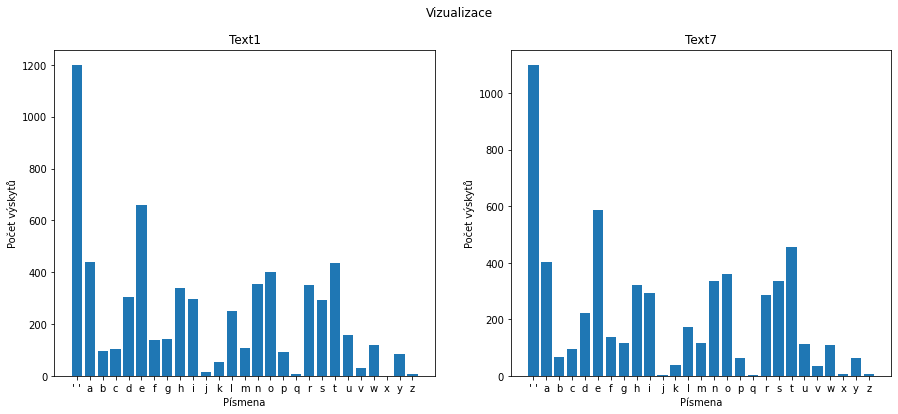

In [159]:
from matplotlib import pyplot as plt

def highlight_space(characters: list):
    result = []
    for char in characters:
        if char == " ":
            result.append("' '")
        else:
            result.append(char)
    return result

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
fig.suptitle("Vizualizace")

characters_1, occurences_1 = countOccurences(X1)
ax1.bar(highlight_space(characters_1), occurences_1);
ax1.set_xlabel("Písmena")
ax1.set_ylabel("Počet výskytů")
ax1.set_title("Text1")

characters_7, occurences_7 = countOccurences(X7)
ax2.bar(highlight_space(characters_7), occurences_7);
ax2.set_xlabel("Písmena")
ax2.set_ylabel("Počet výskytů")
ax2.set_title("Text7");

## Odhad matice přechodu markovského řetězce pro první text
Odhad byl proveden pomocí metody maximální věrohodnosti. Text byl nejprve rozdělen na bigramy a následně byly vypočítány pravděpodobnosti jednotlivých přechodů pro každé písmeno - např. pravděpodobnost přechodu z "a" do "b" je vypočtena jako počet výskytů bigramů "ab" ku počtu výskytů všech bigramů začínající písmenem "a"

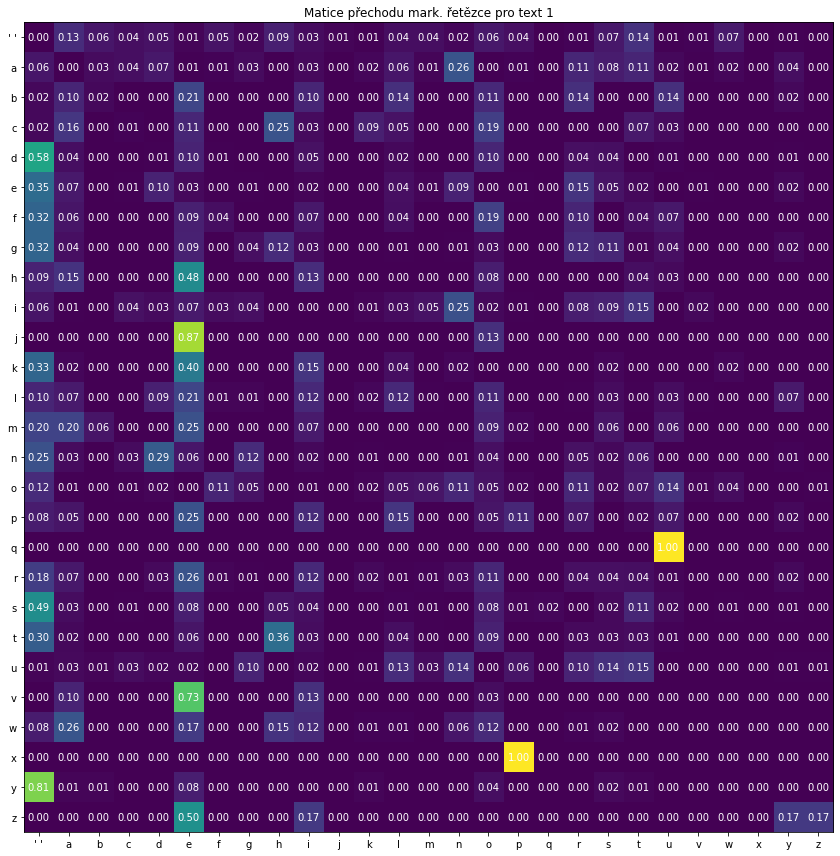

In [67]:
def generateBigrams(X: list):
    return [x + y for x, y in zip(X, X[1:])]

def count_bigrams_with_prefix(y: str, bigrams):
    bigrams_with_prefix = [x for x in bigrams if x.startswith(y)]
    return len(bigrams_with_prefix)

def calc_matrix_P(bigrams):
    matrix = []
    for char_1 in characters_1:
        probabilities = [bigrams.count(char_1 + char_2) / count_bigrams_with_prefix(char_1, bigrams) for char_2 in characters_1]
        matrix.append(probabilities)

    return np.matrix(matrix)

bigrams_1 = generateBigrams(X1)
P = calc_matrix_P(bigrams_1)

fig, ax = plt.subplots(figsize=(15*2, 6*2))
im = ax.imshow(P)
ax.set_xticks(np.arange(len(characters_1)), labels=highlight_space(characters_1))
ax.set_yticks(np.arange(len(characters_1)), labels=highlight_space(characters_1))

# Loop over data dimensions and create text annotations.
for i in range(len(characters_1)):
    for j in range(len(characters_1)):
        text = ax.text(j, i, f"{P[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title("Matice přechodu mark. řetězce pro text 1")
fig.tight_layout()


## Nalezení stacionárního rozdělení
Nalezeno pomocí nalezení null space

In [160]:
import scipy.linalg as la

def StacDist(P): # stacionární rozdělení z matice P
    W = np.transpose(P-np.eye(P.shape[0])) 
    pi = la.null_space(W)
    pi = np.transpose(pi/sum(pi))
    return pi[0]

pi = StacDist(P)
print("pi =", pi)

print("ověření pi*P=pi pomocí výpočtu pi*P - pi -> rozdíl se blíží nule (není přesně nula, protože zde hraje roli nepřesná reprezentace desetinných čísel)", pi@P - pi)

pi = [1.85701455e-01 6.78341305e-02 1.48683688e-02 1.57969408e-02
 4.69257675e-02 1.02054260e-01 2.12168821e-02 2.18437469e-02
 5.21576458e-02 4.59940945e-02 2.32320419e-03 8.05355259e-03
 3.85579518e-02 1.68802201e-02 5.49794124e-02 6.17835873e-02
 1.40939625e-02 9.29470118e-04 5.42195349e-02 4.50821746e-02
 6.73680415e-02 2.46280540e-02 4.64599513e-03 1.81201599e-02
 1.54862306e-04 1.28573721e-02 9.29152731e-04]
ověření pi*P=pi pomocí výpočtu pi*P - pi -> rozdíl se blíží nule (není přesně nula, protože zde hraje roli nepřesná reprezentace desetinných čísel) [[ 8.32667268e-17  1.38777878e-17 -4.51028104e-17  2.42861287e-17
  -6.93889390e-18  1.38777878e-17  3.46944695e-18  3.46944695e-18
  -6.93889390e-18 -6.93889390e-18 -9.54097912e-18 -1.56125113e-17
   0.00000000e+00  0.00000000e+00 -6.93889390e-18 -1.38777878e-17
   3.46944695e-18  7.37257477e-18  0.00000000e+00 -6.93889390e-18
  -2.77555756e-17 -6.93889390e-18  2.60208521e-18  3.46944695e-18
  -5.85469173e-18 -1.73472348e-17  3.2

## Na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků druhého textu se rovná rozdělení π z předchozího bodu
$H_0:$ rozdělení znaků v textu 7 je rovno rozdělení π z předchozího bodu vs. $H_A:$ rozdělení je jiné

Jedná se o Multinomické rozdelení -> test provedu pomocí chí-kvadrát testu při známých parametrech

Celkový počet písmen v textu 7 je 5833


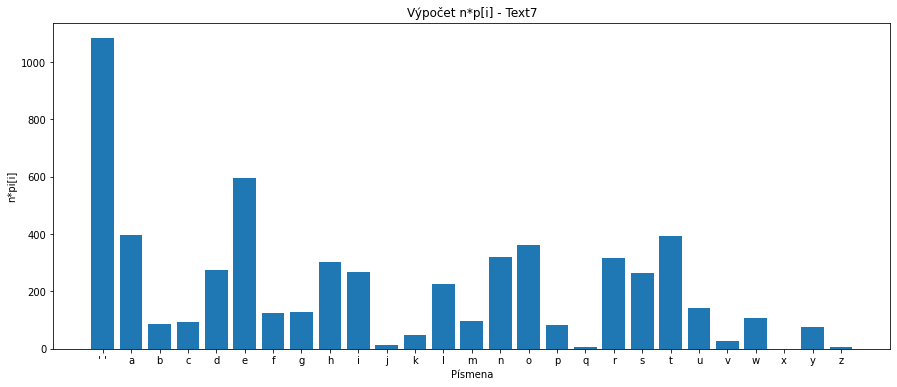

kontrola podmínky n*p[i] ≥ 5
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True]
Číselné hodnoty:
[1.08319659e+03 3.95676483e+02 8.67271952e+01 9.21435559e+01
 2.73718002e+02 5.95282497e+02 1.23758073e+02 1.27414576e+02
 3.04235548e+02 2.68283553e+02 1.35512501e+01 4.69763723e+01
 2.24908533e+02 9.84623241e+01 3.20694913e+02 3.60383665e+02
 8.22100830e+01 5.42159920e+00 3.16262547e+02 2.62964325e+02
 3.92957786e+02 1.43655439e+02 2.71000896e+01 1.05694893e+02
 9.03311831e-01 7.49970515e+01 5.41974788e+00]
Pro jediné písmeno 'x' je podmínka  n*p[i] ≥ 5 neplatná. Sloučil jsem tedy výskyty 'x' s písmenem 'z', které má nejméně počtu výskytů hned po x


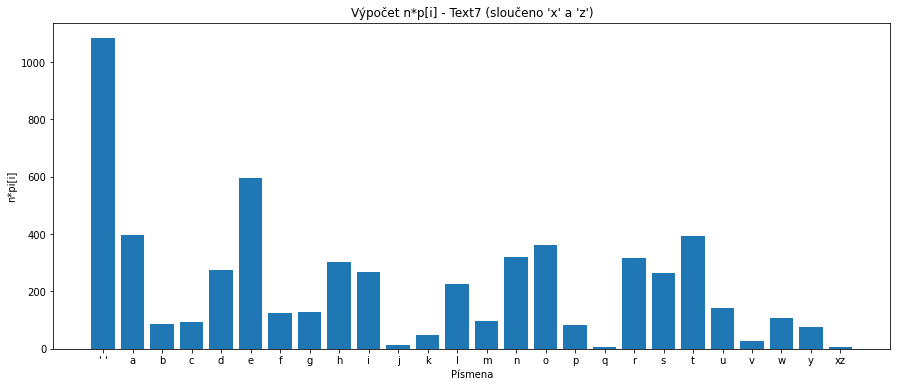

kontrola podmínky n*p[i] ≥ 5
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'xz']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
Číselné hodnoty:
[1083.19658867  395.67648329   86.72719519   92.14355591  273.71800191
  595.28249659  123.758073    127.41457567  304.23554769  268.28355324
   13.55125007   46.97637227  224.90853275   98.46232408  320.69491253
  360.38366457   82.210083      5.4215992   316.26254732  262.96432472
  392.95778597  143.65543897   27.10008958  105.69489264   74.99705146
    6.32305971]


In [163]:
α = 0.05

print("Celkový počet písmen v textu 7 je", np.sum(occurences_7))

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.bar(highlight_space(characters_1), np.sum(occurences_7) * pi)
ax1.set_xlabel("Písmena")
ax1.set_ylabel("n*pi[i]")
ax1.set_title("Výpočet n*p[i] - Text7")
plt.show()

print("kontrola podmínky n*p[i] ≥ 5")
print(characters_1)
print((np.sum(occurences_7) * pi) >= 5)
print("Číselné hodnoty:")
print(np.sum(occurences_7) * pi)
print("Pro jediné písmeno 'x' je podmínka  n*p[i] ≥ 5 neplatná. Sloučil jsem tedy výskyty 'x' s písmenem 'z', které má nejméně počtu výskytů hned po x")

occurences_7_combined = np.concatenate((occurences_7[0:-3], [occurences_7[-2], occurences_7[-3] + occurences_7[-1]]))
pi_combined = np.concatenate((pi[0:-3], [pi[-2], pi[-3] + pi[-1]]))
characters_7_combined = characters_7[:-3] + [characters_7[-2], characters_7[-3] + characters_7[-1]]  

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.bar(highlight_space(characters_7_combined), np.sum(occurences_7_combined) * pi_combined)
ax1.set_xlabel("Písmena")
ax1.set_ylabel("n*pi[i]")
ax1.set_title("Výpočet n*p[i] - Text7 (sloučeno 'x' a 'z')")
plt.show()


print("kontrola podmínky n*p[i] ≥ 5")
print(characters_7_combined)
print( (np.sum(occurences_7_combined) * pi_combined) >= 5)
print("Číselné hodnoty:")
print(np.sum(occurences_7_combined) * pi_combined)


In [149]:
statistic, pvalue = stats.chisquare(occurences_7_combined, pi_combined * np.sum(occurences_7_combined))
print(f"pvalue = {pvalue} < {α} = α => zamítáme H0 (rozdělení znaků v textu 7 je rovno rozdělení π z předchozího bodu) ve prospěch HA na hladině významnosti {α}")

pvalue = 3.021284468765915e-11 < 0.05 = α => zamítáme H0 (rozdělení znaků v textu 7 je rovno rozdělení π z předchozího bodu) ve prospěch HA na hladině významnosti 0.05
